##**This is a first apporach to SOM neural networks and the probability of fraude.**

In [1]:
!pip install MiniSom

  Created wheel for MiniSom: filename=MiniSom-2.2.9-py3-none-any.whl size=8595 sha256=d3fabb955bed3388ce72fed49e4a4eeaf97338429c426714216de084ce8dc7ec
  Stored in directory: /root/.cache/pip/wheels/3d/a1/10/f50b6f4865652eac239a2700de411c3078c27e1318320e494c
Successfully built MiniSom


In [2]:
# Importación de librerías
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Importando Sets de Datos
dataset="/content/drive/My Drive/Colab Notebooks/Entrev FRaude/Credit_Card_Applications.csv"

df=pd.read_csv(dataset)
df.tail()

,CustomerID,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,Class
685,15808223,1,31.57,10.500,2,14,4,6.500,1,0,0,0,2,0,1,1
686,15769980,1,20.67,0.415,2,8,4,0.125,0,0,0,0,2,0,45,0
687,15675450,0,18.83,9.540,2,6,4,0.085,1,0,0,0,2,100,1,1
688,15776494,0,27.42,14.500,2,14,8,3.085,1,1,1,0,2,120,12,1
689,15592412,1,41.00,0.040,2,10,4,0.040,0,1,1,0,1,560,1,1


Donde la clase 0 representa a los individuos que no han cometido fraude y 1, a los que sí lo han cometido.

In [5]:
# Importando Sets de Datos
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

Se usará el escalado de categorías MinMax

In [6]:
# Escalado de Categorias
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
X = sc.fit_transform(X)

**Entrenamiento de MAO: Mapa Auto Organizado  (en Inglés Som)**

Recordemos que un som/mao trabaja a nivel "doble", mostrando por una lado cómo se distribuyen los datos dentro del espacio (vectorial) en el que se "mueven" y la imagen de fondo representa la matriz de los mismos


In [7]:

from minisom import MiniSom
som = MiniSom(x = 10, y = 10, input_len = 15, sigma = 1.0, learning_rate = 0.5)
som.random_weights_init(X)
som.train_random(data = X, num_iteration = 100)


El mapa de distancia media de los pesos se utiliza como fondo (los valores se muestran en la barra de colores de la derecha).
Cada tipo de marcador representa una clase de los datos: infividuos que han cometido fraude, e individuos que no.

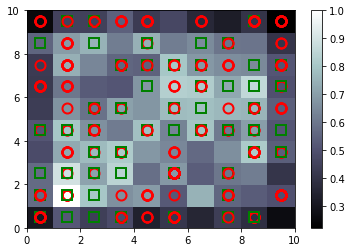

In [ ]:
# Visualizando Resultados
from pylab import bone, pcolor, colorbar, plot, show
bone()
pcolor(som.distance_map().T)
colorbar()
markers = ['o', 's']
colors = ['r', 'g']
for i, x in enumerate(X):
    w = som.winner(x)
    plot(w[0] + 0.5,
         w[1] + 0.5,
         markers[y[i]],
         markeredgecolor = colors[y[i]],
         markerfacecolor = 'None',
         markersize = 10,
         markeredgewidth = 2)
show()

Se puede observar, en el diagrama anterior, que existen algunos casos donde no hay una separación adecuada ya que los cuadrados verdes se solapan con las circunferencias rojas.
La matriz (representados por los cuadrados de fondo en tonalidades grises) indica dónde están las neuronas cercanas (mientras más oscura, más cercana) y dónde están las neuronas aisladas (más claras significa más aisladas).


In [ ]:
# Encontrando Fraude
mappings = som.win_map(X)
frauds = np.concatenate((mappings[(1,1)], mappings[(2,1)], mappings[(9,7)]), axis = 0)
frauds = sc.inverse_transform(frauds)

### Parte 2 - Pasando de Aprendizaje No Supervisado  a aprendizaje  Supervisado

In [ ]:
# Creando Matriz de Categorias
customers = df .iloc[:, 1:].values

In [ ]:
len(df)

690

In [ ]:
len(frauds)

24

In [ ]:
# Creando Variable Dependiente
is_fraud = np.zeros(len(df))
for i in range(len(df)):
    if df.iloc[i,0] in frauds:
        is_fraud[i] = 1

In [ ]:
# Escalado de Categorias
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
customers = sc.fit_transform(customers)

### Part 3 - Creando Red Neuronal

In [ ]:
# Importando paquetes
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# Iniciando RNA
classifier = Sequential()

In [ ]:
# Capa Input y Primera Capa Oculta
classifier.add(Dense(units = 2, kernel_initializer = 'uniform', activation = 'relu', input_dim = 15))

In [ ]:
# Capa Output
classifier.add(Dense(units = 1, kernel_initializer = 'uniform', activation = 'sigmoid'))


In [ ]:
# Compilando Red
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [ ]:
# Encajando Red Neuronal en Set de Entrenamiento
classifier.fit(customers, is_fraud, batch_size = 1, epochs = 2)

Epoch 1/2
690/690 [==============================] - 1s 1ms/step - loss: 0.4965 - accuracy: 0.9609
Epoch 2/2
690/690 [==============================] - 1s 1ms/step - loss: 0.2185 - accuracy: 0.9652


In [ ]:

# Prediccion de Fraude Basado en Probabilidad
y_pred = classifier.predict(customers)
y_pred = np.concatenate((df.iloc[:, 0:1].values, y_pred), axis = 1)
y_pred = y_pred[y_pred[:, 1].argsort()]

A continuación se listan cada una de las distintas probabilidades de los elementos del dataset.



In [ ]:
s = [[str(e) for e in row] for row in y_pred]
lens = [max(map(len, col)) for col in zip(*s)]
fmt = '\t'.join('{{:{}}}'.format(x) for x in lens)
table = [fmt.format(*row) for row in s]
print ('id                 probability of fraud')
print ('\n'.join(table))

id                 probability of fraud
15621423.0	0.0038351118564605713
15570947.0	0.007211476564407349 
15777994.0	0.008053600788116455 
15597536.0	0.008101224899291992 
15697310.0	0.008220165967941284 
15730793.0	0.008596688508987427 
15764444.0	0.00864553451538086  
15728082.0	0.00875866413116455  
15592326.0	0.008762568235397339 
15571284.0	0.008870512247085571 
15585855.0	0.009233295917510986 
15665374.0	0.009830296039581299 
15644446.0	0.010393470525741577 
15803378.0	0.010436683893203735 
15675176.0	0.01055958867073059  
15693382.0	0.010582298040390015 
15799785.0	0.010808855295181274 
15654859.0	0.010811835527420044 
15810723.0	0.010826319456100464 
15740356.0	0.010860592126846313 
15667460.0	0.010924667119979858 
15733602.0	0.011080950498580933 
15752601.0	0.011084884405136108 
15671534.0	0.011313915252685547 
15703177.0	0.011387348175048828 
15602456.0	0.012282401323318481 
15704081.0	0.012544304132461548 
15714087.0	0.01263195276260376  
15641715.0	0.01276099681854248  
155

***Así, como proyecto de negocio, se puede buscar al individuo en particular y ver su probabilidad de fraude.***

***Estimamos que como este es un estudio basado en un resultado que compete a cada individuo (en este caso cada id), no es contingente hacer un análisis colectivo del conjunto de datos.***